In [42]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Classifiers
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder

# Optimization
from hyperopt import fmin, tpe, hp, STATUS_OK

# Seeding
import random
random.seed(42)  # Set random seed for Python
np.random.seed(42)  # Set random seed for NumPy

In [43]:
train = pd.read_csv('../data_format1/train_format1.csv')
user_log = pd.read_csv('../data_format1/user_log_format1.csv')
user_info = pd.read_csv('../data_format1/user_info_format1.csv')
test = pd.read_csv('../data_format1/test_format1.csv')

In [44]:
train.head()

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1
3,34176,2217,0
4,230784,4818,0


In [45]:
test.head()

,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN
3,98688,3645,NaN
4,295296,3361,NaN


In [46]:
user_log.head()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0
1,328862,844400,1271,2882,2661.0,829,0
2,328862,575153,1271,2882,2661.0,829,0
3,328862,996875,1271,2882,2661.0,829,0
4,328862,1086186,1271,1253,1049.0,829,0


In [47]:
user_info.head()

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


In [48]:
# Merge user info with train dataset
train = train.merge(user_info, on='user_id', how='left')
train.head()

,user_id,merchant_id,label,age_range,gender
0,34176,3906,0,6.0,0.0
1,34176,121,0,6.0,0.0
2,34176,4356,1,6.0,0.0
3,34176,2217,0,6.0,0.0
4,230784,4818,0,0.0,0.0


In [49]:
# User-Level Features
user_features = user_log.groupby('user_id').agg({
    'item_id': 'count',  # Total interactions
    'cat_id': 'nunique',  # Unique categories
    'seller_id': 'nunique',  # Unique merchants
    'brand_id': 'nunique',  # Unique brands
    'time_stamp': 'nunique',  # Active days
    'action_type': ['count', lambda x: (x == 2).sum()]  # Purchases
}).reset_index()

user_features.columns = [
    'user_id', 'total_interactions', 'unique_categories', 
    'unique_merchants', 'unique_brands', 'active_days', 
    'total_actions', 'total_purchases'
]

# Ratio features
user_features['purchase_ratio'] = user_features['total_purchases'] / user_features['total_actions']

user_features.head()

,user_id,total_interactions,unique_categories,unique_merchants,unique_brands,active_days,total_actions,total_purchases,purchase_ratio
0,1,33,6,9,9,5,33,6,0.181818
1,2,63,14,14,15,9,63,14,0.222222
2,3,68,19,23,22,13,68,4,0.058824
3,4,50,13,12,12,10,50,1,0.020000
4,5,173,40,56,59,30,173,13,0.075145


In [50]:
# Merchant-Level Features
merchant_features = user_log.groupby('seller_id').agg({
    'user_id': 'nunique',  # Total users
    'item_id': 'count',  # Total interactions
    'cat_id': 'nunique',  # Unique categories
    'brand_id': 'nunique'  # Unique brands
}).reset_index()

merchant_features.columns = [
    'merchant_id', 'total_users', 'total_interactions', 
    'unique_categories', 'unique_brands'
]

merchant_features.head()

,merchant_id,total_users,total_interactions,unique_categories,unique_brands
0,1,30796,339140,44,2
1,2,936,2371,10,1
2,3,1136,2645,4,1
3,4,1481,3106,7,2
4,5,3652,8192,23,1


In [51]:
# User-Merchant Interaction Features
interaction_features = user_log.groupby(['user_id', 'seller_id']).agg({
    'time_stamp': ['count', 'nunique'],  # Total interactions, active days
    # 'action_type': lambda x: (x == 2).sum()  # Purchases
}).reset_index()

interaction_features.columns = [
    'user_id', 'merchant_id', 'user_merchant_interactions', 
    'user_merchant_active_days', 
    # 'user_merchant_purchases'
]

interaction_features.head()

,user_id,merchant_id,user_merchant_interactions,user_merchant_active_days
0,1,471,1,1
1,1,739,1,1
2,1,925,4,1
3,1,1019,14,1
4,1,1156,1,1


In [52]:
# Merge all features with train dataset
train = train.merge(user_features, on='user_id', how='left')
train = train.merge(merchant_features, on='merchant_id', how='left')
train = train.merge(interaction_features, on=['user_id', 'merchant_id'], how='left')

# Fill missing values
train.fillna(0, inplace=True)

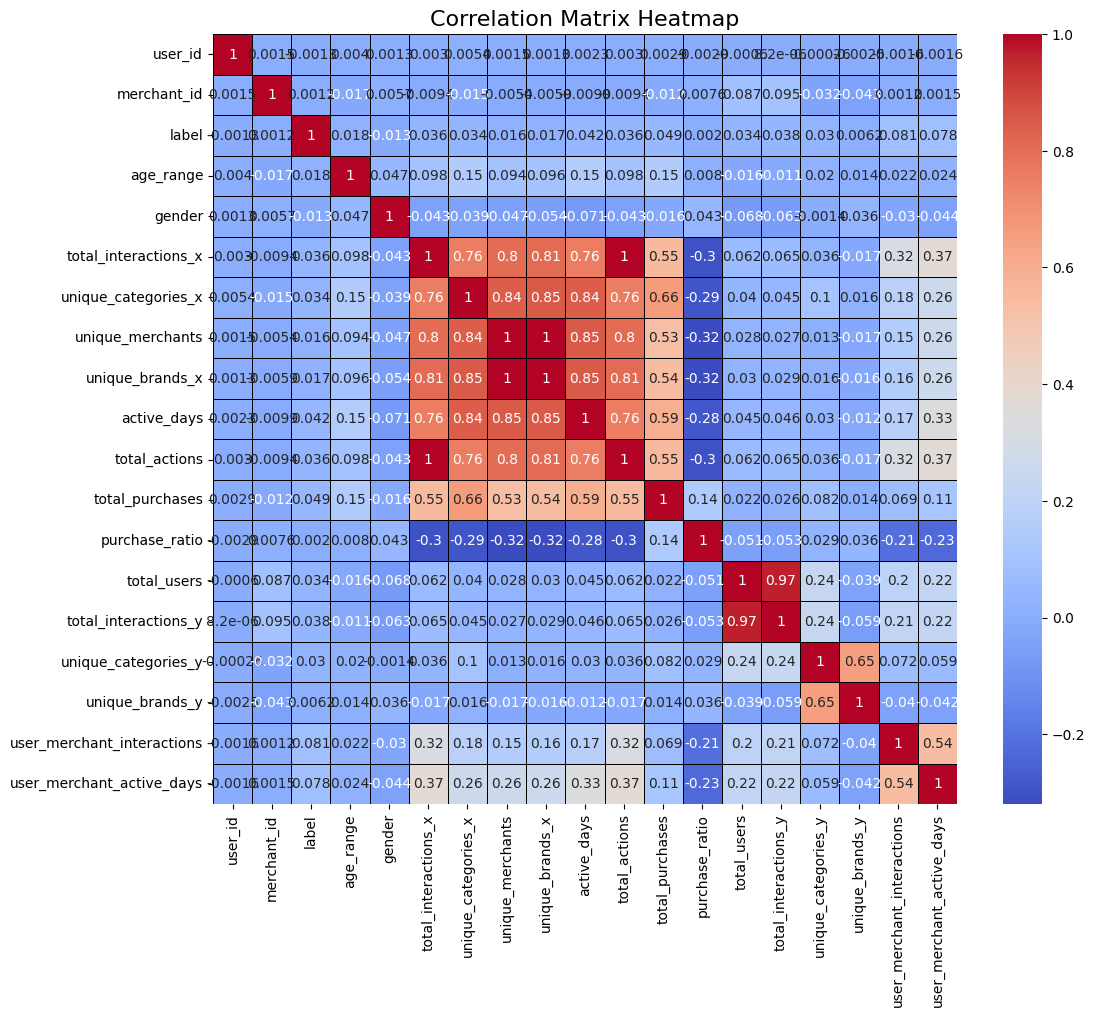

In [53]:
numeric_columns = train.select_dtypes(include=['int64', 'float64']).columns.tolist()

corr_matrix = train[numeric_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.show()

In [60]:
# Eliminate noisy features: Uninformative features can add noise to the model.
filtered_columns = corr_matrix[abs(corr_matrix['label']) >= 0.01].index.tolist()
filtered_columns = [col for col in filtered_columns if col != 'label']
# Display the filtered columns
print(filtered_columns)


['age_range', 'gender', 'total_interactions_x', 'unique_categories_x', 'unique_merchants', 'unique_brands_x', 'active_days', 'total_actions', 'total_purchases', 'total_users', 'total_interactions_y', 'unique_categories_y', 'user_merchant_interactions', 'user_merchant_active_days']


In [61]:
# Prepare data
X = train[filtered_columns]
y = train['label']

scaler_full = StandardScaler()
X_scaled = scaler_full.fit_transform(X)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [62]:
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 100, 1),
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.1),
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 5, 1),
    'subsample': hp.uniform('subsample', 0.5, 1), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1), 
    'gamma': hp.uniform('gamma', 0, 5),                        
    'reg_alpha': hp.uniform('reg_alpha', 0, 5),                
    'reg_lambda': hp.uniform('reg_lambda', 0, 5),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 5, 25)        
}


def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])
    params['n_estimators'] = int(params['n_estimators'])

    xgb_model = XGBClassifier(**params)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_val)
    score = roc_auc_score(y_val, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

best_params_xgb = fmin(objective, space, algo=tpe.suggest, max_evals=100)
print("Best set of hyperparameters: ", best_params_xgb)

100%|██████████| 100/100 [01:05<00:00,  1.53trial/s, best loss: -0.6098084697928275]
Best set of hyperparameters:  {'colsample_bytree': np.float64(0.6970068381794731), 'gamma': np.float64(3.9531216192518963), 'learning_rate': np.float64(0.05621324776756736), 'max_depth': np.float64(8.0), 'min_child_weight': np.float64(3.0), 'n_estimators': np.float64(95.0), 'reg_alpha': np.float64(3.4184322978574535), 'reg_lambda': np.float64(3.10752551621873), 'scale_pos_weight': np.float64(17.650041569701862), 'subsample': np.float64(0.8819780458318783)}


In [63]:
for k, v in best_params_xgb.items():
    if k == 'max_depth' or k == 'min_child_samples' or k == 'n_estimators':
        best_params_xgb[k] = int(v)

xgb_model = XGBClassifier(**best_params_xgb)

xgb_model.fit(X_train, y_train)
prob_preds = xgb_model.predict_proba(X_val)[:, -1]
auroc = roc_auc_score(y_val, prob_preds)
auroc

np.float64(0.6481713411287148)

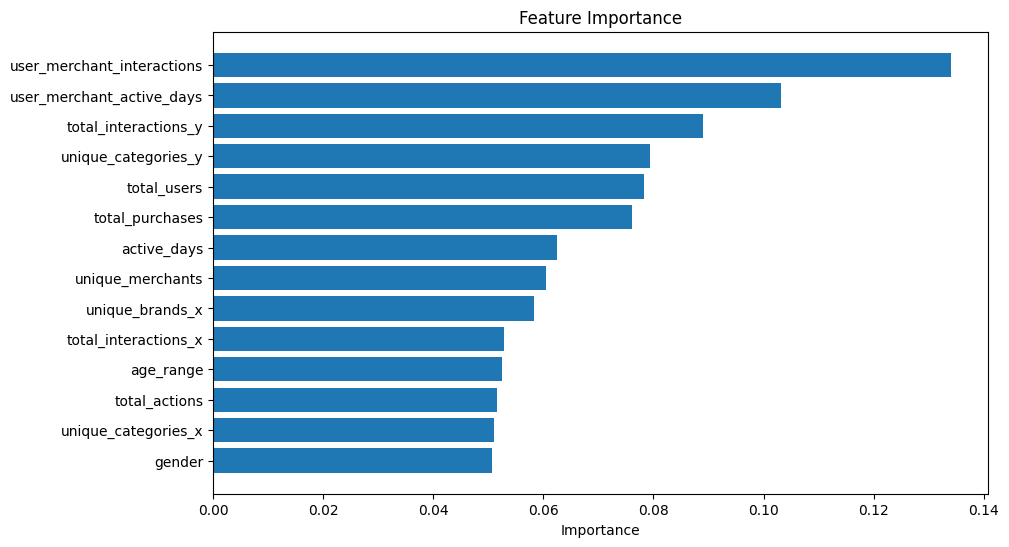

In [64]:
importances = xgb_model.feature_importances_

feature_names = X.columns 
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# test = test.merge(user_info, on='user_id', how='left')
# test = test.merge(user_features, on='user_id', how='left')
# test = test.merge(merchant_features, on='merchant_id', how='left')
# test = test.merge(interaction_features, on=['user_id', 'merchant_id'], how='left')

# test.fillna(0, inplace=True)

# X_test = test[filtered_columns]
# X_test_scaled = scaler_full.transform(X_test)

# test['prob'] = model.predict_proba(X_test)[:, 1]

# # Prepare submission file
# submission = test[['user_id', 'merchant_id', 'prob']]
# submission.to_csv('prediction.csv', index=False)
# print("Submission file created.")